# Предсказание цены автомобиля на вторичном рынке

_Учебный проект в рамках «Мастерской» Яндекс.Практикума_

## Основные выводы

В этом учебном проекте была построена модель машинного обучения, которая предсказывает цену автомобиля на вторичном рынке. В качестве исходных данных использовался датасет об автомобилях, проданных на аукционах. Для оценки качества модели применялась метрика MAPE.

На этапе предобработки данных пришлось обойтись без преобразований, которые казались мне особенно полезными, потому что для таких преобразований нужно профессионально разбираться в рынке подержанных автомобилей США и иметь достаточно времени и других ресурсов — например, чтобы превратить коммерческие названия модификаций автомобилей в объективный рейтинг «навороченности». Также пришлось обойтись довольно примитивной обработкой пропущенных значений, потому что для полноценной обработки следовало бы строить разные модели для разных наборов значений.

По некоторым признакам можно заподозрить элементы искусственного происхождения исходного набора данных: в частности, странно, что за полтора года ни один из 550 тыс. автомобилей не был продан более одного раза.

Строилась регрессионная модель на основе случайного леса (`RandomForestRegressor`). Для подбора гиперпараметров использовался самодельный аналог `GridSearchCV`. Из-за того, что на моём компьютере таким методом модели перебирались недопустимо долго, пришлось ограничиться выбором из 9 моделей с разными гиперпараметрами.

Была выбрана модель с 300 деревьями и максимальной глубиной дерева 20, её MAPE составил 0,167. Предсказания для тестовой выборки сохранены в фа[`ле `submission`](submission.csv)csv`.

Пробег автомобиля оказался главным фактором, от которого зависит цена; на втором месте с большим отрывом — возраст автомобиля.

## Предобработка и исследовательский анализ данных

### Обзор данных

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
SAMPLES = ['train', 'test']
SAMPLES_EXT = SAMPLES + ['combined']

In [3]:
RANDOM_STATE_DEFAULT = 19180511

# If we are to replace standard numerical probability usage with engineering judgment,
# why do we find such an enormous disparity between the management estimate
# and the judgment of the engineers? It would appear that, for whatever purpose, […]
# the management […] exaggerates the reliability of its product, to the point of fantasy.
# -- Richard Feynman in the Rogers Commission Report

В обучающей выборке 440 236 записей, в тестовой — 110 060. Размеры различаются почти точно в 4 раза.

In [4]:
# выборки: df['train'] — обучающая, df['test'] — тестовая
df = dict(zip(SAMPLES, [pd.read_csv(s + '.csv') for s in SAMPLES]))
print(f'Размер выборок: train — {df["train"].shape[0]}, test — {df["test"].shape[0]}'
      f' (разница в {df["train"].shape[0]/df["test"].shape[0]} раза)')

Размер выборок: train — 440236, test — 110060 (разница в 3.9999636561875342 раза)


Наборы столбцов различаются тем, что в обучающей выборке есть столбец `sellingprice`, а в тестовой нет:

In [5]:
diff = df['train'].columns.difference(df['test'].columns)
print('Столбцы из train, которых нет в test:', diff)
print('Столбцы из test, которых нет в train:', df['test'].columns.difference(df['train'].columns))

Столбцы из train, которых нет в test: Index(['sellingprice'], dtype='object')
Столбцы из test, которых нет в train: Index([], dtype='object')


В остальном наборы столбцов и типы их данных идентичны:

In [6]:
print('Наборы столбцов идентичны:', df['train'].drop(diff, axis=1).columns.identical(df['test'].columns))

Наборы столбцов идентичны: True


Для первичного исследования объединим обучающую и тестовую выборки в одну (без столбца `sellingprice`):

In [7]:
df['combined'] = pd.concat([df['train'].drop('sellingprice', axis=1), df['test']])

Чтобы получить общее представление о содержимом выборок, рассмотрим несколько случайных строк:

In [8]:
random.seed(RANDOM_STATE_DEFAULT)
display(df['combined'].iloc[sorted(random.sample(range(df['combined'].shape[0]), 5))])

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
21683,2005,cadillac,srx,awd v6,NaN,automatic,1gyee637850221737,fl,2.1,142275.0,gold,beige,infiniti of tampa,Thu Jan 08 2015 16:30:00 GMT-0800 (PST)
91385,2010,Dodge,Caliber,Mainstreet,Wagon,automatic,1b3cb3ha6ad587595,fl,3.6,69193.0,silver,black,capital one auto finance,Wed Feb 25 2015 01:10:00 GMT-0800 (PST)
95600,2005,Mazda,Mazda6,i,Sedan,manual,1yvhp80c355m66419,hi,2.6,100001.0,orange,black,first hawaiian bank,Tue Dec 23 2014 14:30:00 GMT-0800 (PST)
144352,2008,Chevrolet,Avalanche,LT,Crew Cab,automatic,3gnfk12318g235491,pa,2.9,68036.0,orange,beige,joe ball pontiac gmc commercial trucks,Wed Feb 11 2015 01:30:00 GMT-0800 (PST)
335199,2013,Ford,Explorer,XLT,SUV,automatic,1fm5k7d82dga79222,ga,2.8,27961.0,—,gray,"ford motor credit company,llc pd",Tue May 26 2015 02:30:00 GMT-0700 (PDT)


### Индексация строк

Все значения VIN в датасете уникальны:

In [9]:
print('Дублирующихся значений VIN: ',
      df['combined']['vin'].duplicated().sum())

Дублирующихся значений VIN:  0


Сделаем VIN индексом всех таблиц:

In [10]:
for s in SAMPLES_EXT:
    df[s].set_index('vin', inplace=True, verify_integrity=True)

### Пропущенные значения

В 5 столбцах нет пропущенных значений, почти во всех остальных пропущено не более 2 % значений, и только в столбце `transmission` — 11,7 %:

In [11]:
df_columns = df['combined'].columns.to_frame(name='column', index=False)
# ⚠️ дублирование кода; не успел к дедлайну привести в порядок
df_columns = pd.concat([df_columns,
                        pd.Series([df['combined'][c].dtype
                            for c in df_columns['column']],
                           name='dtype')], axis=1)
df_columns = pd.concat([df_columns,
                        pd.Series([df['combined'][c].isna().sum()
                            for c in df_columns['column']],
                           name='isna')], axis=1)
size_combined = df['combined'].shape[0]
df_columns['%'] = round((df_columns['isna'] / size_combined) * 100, 2)
df_columns.set_index('column', inplace=True)
df_columns

,dtype,isna,%
column,,,
year,int64,0,0.00
make,object,10104,1.84
model,object,10202,1.85
trim,object,10451,1.90
body,object,12987,2.36
transmission,object,64473,11.72
state,object,0,0.00
condition,float64,11784,2.14
odometer,float64,88,0.02


Как обработать пропущенные значения? Я категорически против того, чтобы заполнять какие-то из них фиктивными данными вроде `Unknown` или `Other`, потому что это ухудшит качество датасета. Например, если пропущена марка автомобиля (`make`) — это же не значит, что никакой марки не было. У автомобиля есть марка, причём она более чем наверняка входит в список остальных, не пропущенных марок; просто по какой-то причине она оказалась не внесена в выгрузку. Если в этом случае заменить пропущенное значение на `Unknown`, то модель воспримет это как отдельную, новую марку, что не соответствует действительности. Если же заменить на `Unknown` _все_ пропущенные марки, то модель подумает, будто все эти автомобили относятся к одной марке, что тоже не соответствует действительности.

Если бы у меня было больше времени и квалификации, я бы начал с того, чтобы _реконструировать_ правильные значения там, где это возможно на основании остальных данных. Например, если пропущена марка, но известна модель (`model`) автомобиля,— чаще всего первое можно восстановить по второму. Аналогично, если пропущен тип коробки передач (`transmission`), то в большинстве случаев эта информация однозначно восстанавливается из остальных данных. (Правда, не всегда: здесь пришлось бы каким-то образом добывать и подключать информацию о том, какого типа коробки передач в реальности были у каждой марки, модели и модификации из перечисленных в датасете.)

После реконструкции всё равно останутся пропущенные значения. Мне кажется, что правильнее всего было бы построить _разные_ модели ML для данных разной степени полноты: одну модель — для случая, когда все столбцы заполнены, другую — без столбца `make`, третью — без `trim` и `transmission`, и так для всех сочетаний, которые фактически встречаются в нашем датасете.

В этой работе я иду простым путём и просто избавляюсь от всех пропусков.

#### Цена продажи

В столбце `sellingprice` нет пропущенных значений:

In [12]:
print('Количество пропущенных цен продажи:',
      df['train']['sellingprice'].isna().sum())

Количество пропущенных цен продажи: 0


До тех пор, пока нет отдельных моделей для разных случаев с пропущенными значениями, для всех таких случаев наша модель будет предсказывать медианную цену продажи из обучающей выборки. Эта цена составляет 12,1 тыс. долл. (В условиях задачи не указано, в какой валюте выражены цены, однако поскольку дело происходит в США, логично предположить, что в долларах.)

In [13]:
median_price = df['train']['sellingprice'].median()
print('Медианная цена продажи =', median_price)

Медианная цена продажи = 12100.0


#### Удаляем пропуски

Сохраним индексы строк с пропусками, затем удалим эти строки из датасета:

In [14]:
na_idx = {}
for s in SAMPLES_EXT:
    na_idx[s] = df[s].index[df[s].isna().any(axis=1)].tolist()
    df[s].dropna(inplace=True)

Проверим новый размер выборок:

In [15]:
print(f'Размер выборок: train — {df["train"].shape[0]}, test — {df["test"].shape[0]}'
      f' (разница в {df["train"].shape[0]/df["test"].shape[0]} раза)')

Размер выборок: train — 372090, test — 92806 (разница в 4.009331293235351 раза)


Далее будем исследовать данные без учёта удалённых строк. Это сужает диапазон данных для модели ML: например, из рассмотрения исчезают автомобили, выпущенные до 1990 года, а также некоторые редкие модели. Повторю, что в данном случае я иду на это упрощение из соображений дедлайна.

### Даты

Даты всех продаж лежат в пределах примерно полутора лет: от 01.01.2014 до 20.07.2015. (Сразу можно сказать, что в 2023 году построение моделей по таким данным имеет мало практического смысла, если только мы не хотим специально предсказывать _исторические_ данные.)

In [16]:
dates = pd.to_datetime(df['combined']['saledate'], utc=True)
print('Даты продаж: от', dates.min().date(), 'до', dates.max().date())

C:\Users\Rostislav\AppData\Local\Temp\ipykernel_27416\1726867738.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates = pd.to_datetime(df['combined']['saledate'], utc=True)


Даты продаж: от 2014-01-01 до 2015-07-20


Проданные автомобили выпущены с 1990 до 2015 года:

In [17]:
print('Год выпуска автомобилей: от', df['combined']['year'].min(), 'до', df['combined']['year'].max())

Год выпуска автомобилей: от 1990 до 2015


Введём столбец `age` — возраст автомобиля, то есть количество лет от его выпуска до продажи:

In [18]:
for s in SAMPLES_EXT:
    df[s]['sale_year'] = pd.to_datetime(df[s]['saledate'], utc=True).dt.year
    df[s]['age'] = df[s]['sale_year'] - df[s]['year']
print('Возраст автомобилей (лет): от', df['combined']['age'].min(), 'до', df['combined']['age'].max())

C:\Users\Rostislav\AppData\Local\Temp\ipykernel_27416\2050068047.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[s]['sale_year'] = pd.to_datetime(df[s]['saledate'], utc=True).dt.year
C:\Users\Rostislav\AppData\Local\Temp\ipykernel_27416\2050068047.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[s]['sale_year'] = pd.to_datetime(df[s]['saledate'], utc=True).dt.year
C:\Users\Rostislav\AppData\Local\Temp\ipykernel_27416\2050068047.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[s]['sale_year'] = pd.to_datetime(df[s]['saledate'], utc=True).dt.year


Возраст автомобилей (лет): от -1 до 25


У 157 автомобилей оказался отрицательный возраст: −1 год. Все эти автомобили проданы в 2014 году, а выпущены якобы в 2015. Это в целом приемлемо: нет ничего удивительного в том, что отдельные автомобили проданы за год до их официальной даты выпуска. Это могут быть как автомобили, реально произведённые заранее, так и «фьючерсные» продажи ещё не произведённых автомобилей.

In [19]:
bttf = df['combined'][df['combined']['age'] < 0]
print('Количество автомобилей с отрицательным возрастом:', bttf.shape[0])
print('Годы выпуска этих автомобилей:', bttf['year'].unique().tolist())
bttf_dates = pd.to_datetime(bttf['saledate'], utc=True)
print('Даты продаж этих автомобилей: от', bttf_dates.min().date(), 'до', bttf_dates.max().date())

Количество автомобилей с отрицательным возрастом: 157
Годы выпуска этих автомобилей: [2015]
Даты продаж этих автомобилей: от 2014-01-01 до 2014-12-31


C:\Users\Rostislav\AppData\Local\Temp\ipykernel_27416\2137417018.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bttf_dates = pd.to_datetime(bttf['saledate'], utc=True)


Зато тот факт, что даты продаж ровно вписываются в 2014 год (минимальная дата — самый первый день года, максимальная — самый последний), несколько настораживает и позволяет заподозрить фактор искусственности при комплектовании исходного датасета.

Ещё отмечу, что в датасете нет данных о том, чтобы один и тот же VIN продавался бы более одного раза. Для набора из ~550 тыс. автомобилей за полтора года это более чем странно. В реальной жизни я бы уточнил у заказчика, каким образом формировался датасет: как отбирались попавшие в него аукционы из всего множества автомобильных аукционов, откуда брались конкретные данные о продажах, верифицировались ли они, не фильтровались ли и т. д. В нашем учебном случае могу только сказать, что это ещё один довод в пользу искусственности.

Столбцы с датами больше не нужны. Заодно удалим и столбец `seller` (продавец), потому что он вряд ли существенно влияет на цену:

In [20]:
for s in SAMPLES_EXT:
    df[s].drop(['year', 'saledate', 'sale_year', 'seller'], axis=1, inplace=True)

### Текстовые столбцы

Приведём текстовые столбцы к единому регистру, чтобы избежать разночтений типа `Sedan/sedan`:

In [21]:
for s in SAMPLES_EXT:
    for column in ['make', 'model', 'body']:
        df[s][column] = df[s][column].str.lower()

К сожалению, в предложенных обстоятельствах нет никакой возможности провести такую предобработку текстовых столбцов, которая на самом деле принесёт пользу и, вероятно, радикально улучшит качество модели:

- Привести типы кузова (`body`) к единой системе из 7–10 основных типов (например, за отправную точку взять [Car body style](https://en.wikipedia.org/wiki/Car_body_style) из Википедии). Возможно, ввести двухуровневую классификацию типов кузова.
- сделать модификацию (`trim`) порядковым значением, которое отражает «степень навороченности» автомобиля (в рамках его модельного ряда или глобально).
- добавить классификацию по сегментам рынка (например, за отправную точку взять [Car classification](https://en.wikipedia.org/wiki/Car_classification) из Википедии).

Для этого необходимо глубоко разбираться в американском рынке автомобилей, а также потратить время и силы на глубокую переработку данных. Если бы это была реальная коммерческая задача, я бы поставил перед заказчиком вопрос о том, что без подобных мер мы не получим сколько-либо адекватной модели, сколько ни выдрючивай MAPE или другие метрики на стадии обучения и валидации.

#### Удаляем лишние столбцы

Без такой предобработки данные о модификациях представляют собой просто мусор из 1,5 тыс. хаотичных значений, так что столбец `trim` можно просто удалить. Заодно удалим штат (`state`), чтоб два раза не ходить:

In [22]:
print('Количество уникальных модификаций:', len(df['combined']['trim'].unique()))
for s in SAMPLES_EXT:
    df[s].drop(['trim', 'state'], axis=1, inplace=True)

Количество уникальных модификаций: 1506


#### Сокращаем непопулярные опции

В датасете 764 модели автомобилей и 45 типов кузова. Попробуем сфокусировать модель только на самых популярных опциях, заменив остальные на `other`.

In [23]:
# ⚠️ дублирование кода; не успел к дедлайну привести в порядок

model_dist = df['combined']['model'].value_counts(normalize=True).cumsum()
model_pct = .75
print('Всего моделей:', len(df['combined']['model'].unique()))
print(f'{len(model_dist.index[model_dist <= model_pct])} модели занимают ~75 % всего датасета')

model_tail = model_dist.index[model_dist > model_pct].tolist()
for s in SAMPLES_EXT:
    df[s].loc[df[s]['model'].isin(model_tail), 'model'] = 'other'

body_dist = df['combined']['body'].value_counts(normalize=True).cumsum()
body_pct = .975
print('Всего типов кузова:', len(df['combined']['body'].unique()))
print(f'{len(body_dist.index[body_dist <= body_pct])} типов кузова занимают ~97,5 % всего датасета')

body_tail = body_dist.index[body_dist > body_pct].tolist()
for s in SAMPLES_EXT:
    df[s].loc[df[s]['body'].isin(body_tail), 'body'] = 'other'

Всего моделей: 764
104 модели занимают ~75 % всего датасета
Всего типов кузова: 45
13 типов кузова занимают ~97,5 % всего датасета


## Работа с моделью

### Подготовка данных

In [24]:
# x — прогнозирующие признаки, y — целевые
# Например, x['train'] — прогнозирующие признаки обучающей выборки
x, y = [{'train': None, 'test': None} for _ in range(2)]
df['test']['sellingprice'] = 0

for s in SAMPLES:
    x[s] = df[s].drop('sellingprice', axis=1)
    y[s] = df[s].sellingprice

In [25]:
# Категориальные и числовые признаки
numeric_columns = ['condition', 'odometer', 'age']
category_columns = x['train'].columns.difference(numeric_columns)

In [26]:
# Преобразуем категориальные признаки прямым кодированием…
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(x['train'][category_columns])

# …а числовые признаки — нормированием
scaler = StandardScaler()
scaler.fit(x['train'][numeric_columns])

# Применим обученные преобразования к обучающей и тестовой выборкам
for s in SAMPLES:
    x[s] = pd.concat([pd.DataFrame.sparse.from_spmatrix(ohe.transform(x[s][category_columns]),
                                columns=ohe.get_feature_names_out(category_columns)),
                   pd.DataFrame(scaler.transform(x[s][numeric_columns]),
                                columns=numeric_columns)], axis=1)

### Подбор модели

Будем использовать **случайный лес**, который лучше всего зарекомендовал себя в предыдущих учебных проектах.

#### Алгоритм подбора

До недавнего времени я не знал о существовании функции `GridSearchCV()`, поэтому придумал собственную функцию, которая делает что-то похожее.

Для случайного леса самым простым решением было бы перебрать во вложенном цикле все возможные комбинации гиперпараметров:

```python
for depth in range(1, много):  # максимальная глубина дерева
    for est in range(1, много):  # количество деревьев
        model = RandomForestRegressor(max_depth=depth, n_estimators=est, …)
        # обучаем модель, вычисляем метрику, находим максимум по всем моделям…
```

Однако с таким полным перебором не справляется даже мой локальный компьютер. По опыту я считаю разумным проверять глубину дерева в диапазоне до 50 уровней, а количество деревьев — до 1000; построение 50 × 1000 = 50 000 моделей на имеющихся данных заняло бы на моём компьютере несколько месяцев. Кроме того, эту операцию пришлось бы повторять неоднократно по мере доработки и оптимизации кода.

Поэтому я действую по такому алгоритму:

1. Перебрать _разреженные_ диапазоны параметров. В этой задаче я начал всю процедуру с такого цикла:

```python
for depth in range(10, 21, 5):  # максимальная глубина дерева
    for est in range(100, 301, 100):  # количество деревьев
```

2. Рассмотреть локальные максимумы MAPE (или другой метрики), полученные на предыдущем этапе, и перебрать параметры в окрестностях этих максимумов. В зависимости от ситуации параметры перебираются либо сразу с шагом 1, либо через промежуточный разреженный диапазон (например, для количества деревьев — с шагом 5).

К сожалению, в данной задаче п. 2 не удался, потому что п. 1 занял полдня, и если бы я продолжал в том же духе, то вышел бы за все дедлайны. Также я изучал Optuna, но за имеющееся время не успел разобраться в ней настолько, чтобы эффективно применить вместо своего «велосипеда».

Так что для обнаружения максимумов MAPE используется функция `sort_models()` и вспомогательная визуализация средствами seaborn.

In [37]:
def sort_models(depth_range, est_range):
    '''Датафрейм с параметрами моделей:
    количество деревьев, максимальная глубина, MAPE.
    Датафрейм отсортирован от лучшего MAPE к худшему
    '''
    results = pd.DataFrame(columns=['n_estimators', 'max_depth', 'mape'])
    for depth in depth_range:
        for est in est_range:
            model = RandomForestRegressor(max_depth=depth, n_estimators=est,
                random_state=RANDOM_STATE_DEFAULT)
            res = cross_validate(model, x['train'], y['train'],
                scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
            mape_max = res['test_score'].max()
            results.loc[len(results.index)] = [est, depth, mape_max]
    return results

Для визуализации использовался `seaborn.scatterplot()`, например:

```python
sns.scatterplot(data=res, x='n_estimators', y='max_depth',
    hue='mape', size='mape', sizes=(5, 2000), palette='Spectral', legend=False)
plt.title('MAPE')
pshow()
```
В моём ём случае получилась такая диаграмма:

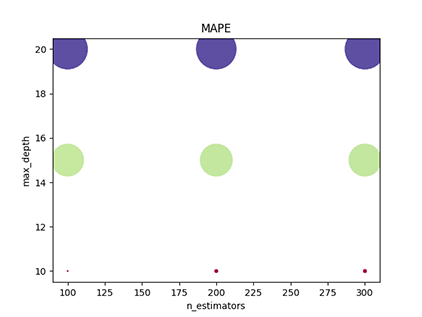``


#### Построение модели

Используем лучшую из 9 исследованных моделей:

In [27]:
model = RandomForestRegressor(max_depth=20, n_estimators=300, n_jobs=-1,
                              random_state=RANDOM_STATE_DEFAULT)
model.fit(x['train'], y['train'])

MAPE для этой модели равно 0,167…

In [38]:
print('MAPE =', mean_absolute_percentage_error(model.predict(x['train']), y['train']))

C:\Users\Rostislav\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


MAPE = 0.16703915140270434


### Формирование выходных данных

In [31]:
y['test'] = pd.Series(data=model.predict(x['test']), index=y['test'].index)

C:\Users\Rostislav\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [39]:
# к выходным данным, кроме значений, которые предсказала модель,
# добавляем ранее выброшенные vin с одинаковым медианным предсказанием
output = pd.concat([y['test'], pd.Series(data=median_price, index=na_idx['test'])])
output.name = 'sellingprice'

# создаём файл submission.csv в соответствии с условиями задачи
output.to_csv('submission.csv', index_label='vin', header='sellingprice')

### Важность признаков

Анализ важности признаков показывает, что пробег (`odometer`) влияет на цену не менее чем в 4 раза больше, чем любой из остальных признаков. Также важен возраст (`age`), остальные параметры гораздо менее важны. При наличии ресурсов можно было бы перестроить модель только на основании `odometer` и `age` и сравнить, будет ли она сильно хуже имеющейся модели с богатым ассортиментом параметров.

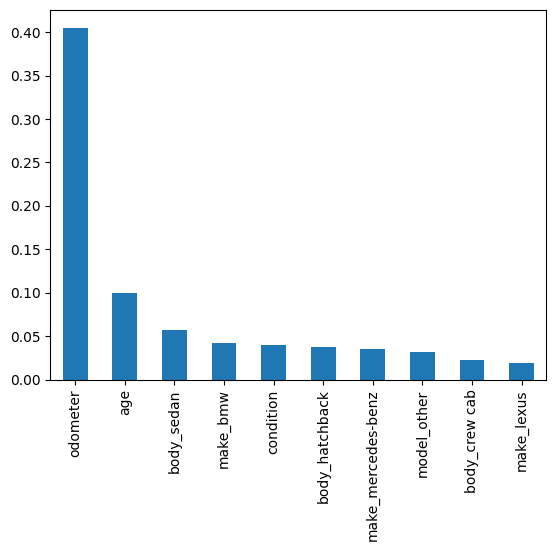

In [41]:
pd.Series(model.feature_importances_,
          index=x['train'].columns).sort_values(ascending=False).head(10).plot.bar()
plt.show()